Upload data to sqlite tables.

In [1]:
import pandas as pd
import numpy as np
from IPython import display as dis
import scipy.io.wavfile as wav
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq.python.ops.seq2seq import basic_rnn_seq2seq
from tensorflow.contrib.rnn import RNNCell, LSTMCell, MultiRNNCell
from scipy import signal 
from librosa import core

from matplotlib import pyplot as plt
import time

%matplotlib inline

In [2]:
dis.Audio("dataset/wav/Ses01F_impro01/Ses01F_impro01_F011.wav")

In [3]:
time_step = 0
hidden_layers = 1
batch_size = 5
feature_count = 1
latent_dim = 61 

In [4]:
#["batch_size", "steps", "step_size", "feature_count"]
[batch_size, time_step, feature_count ]

[5, 0, 1]

In [5]:
sigs_diff_length = []
sigs = []
time_steps = []
for i in ("07", "08", "09", "10", "11"):
    (sig,rate) = core.load("dataset/wav/Ses01F_impro01/Ses01F_impro01_F0{}.wav".format(i), sr = 8000)
    
    sigs_diff_length.append(sig)
    time_steps.append(len(sig))
    
time_step = max(time_steps)

for sig in sigs_diff_length:
    sig = np.pad(sig, (0, time_step - len(sig)), mode = "constant")
    sig = np.reshape(sig, (-1,1)) 
    sigs.append(sig)

In [6]:
sigs = np.array(sigs)
print(sigs.shape)
time_step = max(time_steps)

print("Signal",sigs[-1], "Rate", rate, "Max time step:", time_step)

(5, 78480, 1)
Signal [[-0.01335607]
 [ 0.00451396]
 [-0.00446299]
 ..., 
 [-0.0015959 ]
 [-0.0017785 ]
 [-0.00236306]] Rate 8000 Max time step: 78480


In [7]:
class Data(object):
    x = sigs + np.random.normal(scale=0.05, size = sigs.shape)
    y_ = sigs

In [8]:
dis.Audio(data = Data.y_[-1].ravel(), rate = rate)

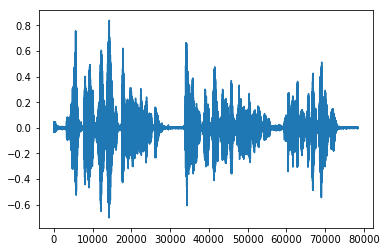

In [9]:
plt.plot(Data.y_[-1])

In [10]:
dis.Audio(data = Data.x[-1].ravel(), rate = rate)

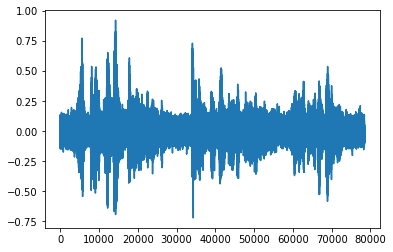

In [11]:
plt.plot(Data.x[-1])

In [12]:
class network(object):
    
    def __init__(self):
        pass
            
    def build_layers(self):
        
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        global time_step 
        global batch_size 
        global hidden_layers
        global step_size
        global latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float32", shape=[batch_size, time_step, feature_count], name='x')
            self.y_ = tf.placeholder("float32", shape=[batch_size, time_step, feature_count], name='y')
            self.seq_length = tf.placeholder("float32", shape=[batch_size])
            
            #self.x = tf.nn.l2_normalize(self.x, dim = 0)
            #self.y_ = tf.nn.l2_normalize(self.y_, dim = 0)
            
            self.keep_prob = tf.placeholder("float", name='kp')
            self.lr = tf.placeholder("float", name='lr')
            
        with tf.variable_scope("encoder"):
            enc_lstm = tf.contrib.rnn.LSTMCell(latent_dim)
            
            self.state = enc_lstm.zero_state(batch_size, "float")
            print("State:",self.state)
            
            print("Audio Input:", self.x)
            self.enc_output, self.state = tf.nn.dynamic_rnn(enc_lstm, self.x, initial_state = self.state)
            print("Encoder Output:",self.enc_output)

        with tf.variable_scope("decoder"):
            dec_lstm = tf.contrib.rnn.LSTMCell(latent_dim)
            self.dec_output, self.state = tf.nn.dynamic_rnn(dec_lstm, self.enc_output, initial_state = self.state)
            
            self.output = tf.layers.dense(self.dec_output, units = 1)
            print("Decoder Output:",self.dec_output)
            
        with tf.variable_scope("Optimize"):
            #loss = tf.contrib.seq2seq.sequence_loss(self.output, self.x, tf.ones(shape=[batch_size, time_step]))
            self.loss = tf.losses.mean_squared_error(self.y_, self.output)
            optimizer = tf.train.AdamOptimizer(self.lr)
            self.opti_op = optimizer.minimize(self.loss)
        print("Final Output:", self.output)

            
        

In [13]:
import collections

y_pred_list = []
final_state = None
class Train:    
    
    def train(net, epochs, lrs, x, y):
        global final_state
        
        with tf.Session() as sess:
            
            sess.run(tf.global_variables_initializer())
            for lr in lrs:
                for epoch in range(1, epochs+1):

                    x_train = x
                    y_train = y

                    _, Data.state, Data.x_norm, Data.y_norm, Data.y, Data.loss = sess.run(
                                                                                        [net.opti_op, net.state, net.x, net.y_, net.output, net.loss], #net.summary_op
                                                                                          feed_dict={net.x: x_train, 
                                                                                                     net.y_: y_train,
                                                                                                     net.seq_length:time_steps,
                                                                                                     net.keep_prob:1,
                                                                                                     net.lr:lr})
                    print("Step {} lr {} Loss {}".format(epoch, lr, Data.loss))


In [ ]:
import itertools

class Hyperparameters:
    def start_training():
        
        epochs = 100
        lrs = [1e-3]
        n = network()
        n.build_layers()
        
        Train.train(n, epochs, lrs, Data.x, Data.y_)
            

In [ ]:
Hyperparameters.start_training()

State: LSTMStateTuple(c=<tf.Tensor 'encoder/LSTMCellZeroState/zeros:0' shape=(5, 61) dtype=float32>, h=<tf.Tensor 'encoder/LSTMCellZeroState/zeros_1:0' shape=(5, 61) dtype=float32>)
Audio Input: Tensor("Input/x:0", shape=(5, 78480, 1), dtype=float32)
Encoder Output: Tensor("encoder/rnn/transpose:0", shape=(5, 78480, 61), dtype=float32)
Decoder Output: Tensor("decoder/rnn/transpose:0", shape=(5, 78480, 61), dtype=float32)
Final Output: Tensor("decoder/dense/BiasAdd:0", shape=(5, 78480, 1), dtype=float32)
Step 1 lr 0.001 Loss 0.003147431882098317
Step 2 lr 0.001 Loss 0.0030922596342861652
Step 3 lr 0.001 Loss 0.00323630403727293
Step 4 lr 0.001 Loss 0.0030083064921200275
Step 5 lr 0.001 Loss 0.003083675866946578
Step 6 lr 0.001 Loss 0.003053638618439436
Step 7 lr 0.001 Loss 0.002938249846920371
Step 8 lr 0.001 Loss 0.002888645976781845
Step 9 lr 0.001 Loss 0.0029108335729688406
Step 10 lr 0.001 Loss 0.002893394324928522
Step 11 lr 0.001 Loss 0.002824007999151945
Step 12 lr 0.001 Loss 0.0

In [ ]:
#Data.output = np.array(Data.output)
print(Data.state.c)

In [ ]:
Data.context = np.array(Data.state.c)
print(Data.context.shape)
pd.DataFrame(Data.context).to_pickle("network_learned.pkl")

In [ ]:
plt.plot(Data.context[-1])

In [ ]:
plt.plot(Data.x[-1] / ( max(abs(Data.x[-1]) )))

In [ ]:
plt.plot(Data.x[-1])

In [ ]:
plt.plot(Data.y_[-1])

In [ ]:
plt.plot(Data.y[-1])

In [ ]:
y = Data.x[-1].ravel()
dis.Audio(data = y, rate = rate)

In [ ]:
y = Data.y[-1].ravel()
dis.Audio(data = y, rate = rate)